In [1]:
!sudo pip install -qr requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import ddim.models as models
from ddim.models.model_utils import get_default_channel_mult, load_params
from ddim.diffusion.parameters import linear_beta_schedule, diff_params_from_betas
from ddim.diffusion.inference import denoising_loop
from ddim.training.steps import get_train_loop
from ddim.training.ema import EMA
from ddim.training.data import TimestepSampler, ImageDataset, DatasetSampler

import numpy as np
import random
import pickle

import jax
from jax import numpy as jnp
from jax.experimental.pjit import pjit, PartitionSpec
from jax.experimental.maps import mesh
import optax

import flax.nn.stochastic as flax_stochastic

import jmp
import time

import json
import tensorboardX
from tensorboardX import SummaryWriter

import os
import socket
from datetime import datetime
import copy

In [3]:
DATA_DIR = "../local_data/portraits"
LOG_PREFIX = "../share_data/runs/active"
OUT_PREFIX = "../cloud_data/models"

In [4]:
# Config
config = {
    "seed": 1337,
    "mesh_shape": (1, 4, 2),
    "resume": None,
    "prefix": "128px_unet_wide_deep_drop",
    "log_prefix": LOG_PREFIX,
    "out_prefix": OUT_PREFIX,
    "training": {
        "learning_rate": 0.0001,
        "adam_b1": 0.9,
        "adam_b2": 0.999,
        "adam_decay": 0.0001,
        "batch_size": 1,
        "train_steps_total": 1000000000,
        "train_steps_per_iter": 2500,
        "eval_every": 10000,
        "save_every": 100000,
        "reduce_lr_steps": 100000,
        "reduce_lr_thresh": -0.000000001,
        "mixed_precision": True,
    },
    "data": {
        "data_glob": os.path.join(DATA_DIR, "*.jpg"),
        "image_size": 128,
        "image_base_size": 512,
        "image_channels": 3,
    },
    
    # Mixer config (not recommended, needs work)
    #"model_type": "MlpMixer",
    #"model": {
    #    "patches": (16, 16),
    #    "num_blocks": 23,
    #    "timestep_inject_every": 3,
    #    "timestep_inject_to": 18,
    #    "hidden_per_channel": 384,
    #    "tokens_mlp_dim": 512,
    #    "channels_mlp_dim": 3072,
    #    "out_stage_dim_per_channel": 16,
    #    "out_stage_kernel_dim": 4,
    #},
    
    # UNet config (like OpenAI)
    "model_type": "UNet",
    "model": {
        "model_channels": 128,
        "channel_mult": (1, 1, 2, 3, 4, 4),
        "num_head_channels": 64,
        "use_scale_shift_norm": True,
        "num_res_blocks": 2,
        "attention_resolutions": (32, 16, 8, 4),
        "dropout": 0.1
    },
    
    "diffusion": {
        "schedule_steps": 1000,
    }
}

In [5]:
# Basic jax mesh setup
prng = jax.random.PRNGKey(config["seed"])
devices = np.array(jax.devices()).reshape(config["mesh_shape"])

# Precision settings
if config["training"]["mixed_precision"] == True:
    compute_dtype = jnp.bfloat16
else:
    compute_dtype = jnp.float32
    
precision_policy = jmp.Policy(
    compute_dtype = compute_dtype,
    param_dtype = jnp.float32,
    output_dtype = jnp.float32,
)

In [6]:
# Set up model
prefix = config["prefix"]
resume = config["resume"]
model_fun = getattr(models, config["model_type"])

config["model"]["out_channels"] = config["data"]["image_channels"]
config["model"]["dtype"] = precision_policy.compute_dtype
config["model"]["dtype_out"] = precision_policy.compute_dtype

model = model_fun(**config["model"])

if config["resume"] is None:
    # Initialize parameters
    init_pjit = pjit(model.init, [None, PartitionSpec("batch", "x", "y"), PartitionSpec("batch")], PartitionSpec(None))
    with mesh(devices, ('batch', 'x', 'y')):
        params = init_pjit(prng, jnp.zeros((1, config["data"]["image_size"], config["data"]["image_size"], config["data"]["image_channels"])), jnp.zeros((1,)))
else:
    params = load_params(f"params_{prefix}_{resume}.pkl", devices)
    # TODO: Restore optimizer state?
    
params = precision_policy.cast_to_param(params)

"""
param_count = 0
for param in jax.tree_util.tree_flatten(params)[0]:
    param_count += len(param.flatten())
print(f"param count: {param_count}")
"""

# Initialize diffusion
diff_params = diff_params_from_betas(linear_beta_schedule(config["diffusion"]["schedule_steps"]))

/home/lorenzd/.local/lib/python3.8/site-packages/jax/experimental/pjit.py:160: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")


In [7]:
# pjit the denoising loop
def denoising_loop_pjit(params, diff_params, images):
    return denoising_loop(model, params, diff_params, images)

denoising_loop_pjit = pjit(denoising_loop_pjit, 
   [
       PartitionSpec(None),
       PartitionSpec(None),
       PartitionSpec("batch", "x", "y")
   ], 
   PartitionSpec("batch", "x", "y"),
)

In [8]:
# Set up training
ema = EMA()
resize = None
if config["data"]["image_size"] != config["data"]["image_base_size"]:
    resize = config["data"]["image_size"]
dataset = ImageDataset(config["data"]["data_glob"], resize = resize)
data_sampler = DatasetSampler(dataset, batch_size = config["training"]["batch_size"])
timestep_sampler = TimestepSampler(config["diffusion"]["schedule_steps"], config["training"]["batch_size"])

opt = optax.chain(
    optax.adamw(
        b1=config["training"]["adam_b1"], 
        b2=config["training"]["adam_b2"], 
        learning_rate = config["training"]["learning_rate"], 
        eps=1e-8,
        weight_decay = config["training"]["adam_decay"]
    ),
    optax.inject_hyperparams(optax.scale)(1.0), # for LR halving
)
opt_params = opt.init(params)
opt_params_extra = {} # for lr halving data

# Build a train loop that runs for several batches
train_loop = get_train_loop(
    opt, 
    model, 
    diff_params, 
    data_sampler, 
    timestep_sampler, 
    ema, 
    how_many = config["training"]["train_steps_per_iter"],
    precision_policy = precision_policy
)

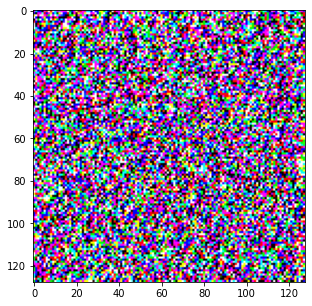

e: 2500, l: 0.07791715115308762, img/s: 8.01
e: 5000, l: 0.043573036789894104, img/s: 11.58
e: 7500, l: 0.040884457528591156, img/s: 13.559999999999999


In [ ]:
# Tensorboard instrumentation
writer = SummaryWriter(logdir = os.path.join(config["log_prefix"], datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname() + "_" + config["prefix"]))
config_copy = copy.deepcopy(config)
config_copy["model"]["dtype"] = str(config_copy["model"]["dtype"])
config_copy["model"]["dtype_out"] = str(config_copy["model"]["dtype_out"])
writer.add_text("config", json.dumps(config_copy, indent=4))

# Train
loss = None
best_loss = jnp.inf
reduce_lr_loss = []
start = time.time()
start_i = 0
if not config["resume"] is None:
    start_i = config["resume"] // config["training"]["train_steps_per_iter"]
    
with mesh(devices, ('batch', 'x', 'y')):
    for i in range(start_i, config["training"]["train_steps_total"] // config["training"]["train_steps_per_iter"]):
        step = i * config["training"]["train_steps_per_iter"]
        if step % config["training"]["eval_every"] == 0:
            # Progress shot
            prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
            images_in = jax.random.normal(prng_img, (1, config["data"]["image_size"], config["data"]["image_size"], config["data"]["image_channels"]))
            timesteps_in = jnp.array([0,], dtype=jnp.int32)
            out = denoising_loop_pjit(params, diff_params, images_in.astype(jnp.float32))
            image = np.array(((out[0, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.show()
            
            # To tensorboard
            writer.add_image("out/image", image.T.transpose(0, 2, 1), i * config["training"]["train_steps_per_iter"])
        
        # Print loss
        img_s = (i - start_i) * round((config["training"]["train_steps_per_iter"] * config["training"]["batch_size"]) / (time.time() - start), 2)
        if not loss is None:
            print(f"e: {step}, l: {np.mean(loss)}, img/s: {img_s}")
        
            # learning rate halving
            reduce_lr_loss.extend(list(np.array(loss).flatten()))
            reduce_lr_loss = reduce_lr_loss[-config["training"]["reduce_lr_steps"]:]
            reduce_lr_loss_arr = jnp.array(reduce_lr_loss)
            best_new_loss = best_loss
            if step != config["training"]["reduce_lr_steps"] and step % config["training"]["reduce_lr_steps"] == 0:
                best_new_loss = reduce_lr_loss_arr.min()
                if best_loss - best_new_loss < config["training"]["reduce_lr_thresh"]:
                    opt_params[1].hyperparams["step_size"] = opt_params[1].hyperparams["step_size"] / 2
                writer.add_scalar("lr/step_diff", best_loss - best_new_loss, i * config["training"]["train_steps_per_iter"])
            best_loss = min(best_loss, best_new_loss)
            
            opt_params_extra["reduce_lr_loss"] = reduce_lr_loss
            opt_params_extra["best_loss"] = best_loss
            
        # Tensorboard update
        if not loss is None:
            writer.add_scalar("images_sec", img_s, step)
            writer.add_scalar("loss/loop", np.mean(loss), step)
            writer.add_scalar("loss/lrstep", np.mean(reduce_lr_loss), step)
            writer.add_scalar("lr/scale", opt_params[1].hyperparams["step_size"], step)
            for idx, loss_v in enumerate(list(np.array(loss))):
                writer.add_scalar("loss/raw", loss_v, step + idx)
            
        # Save parameters
        if step % config["training"]["save_every"] == 0:
            with open(os.path.join(config["out_prefix"], f"params_{prefix}.pkl"), "wb") as f:
                pickle.dump(precision_policy.cast_to_output(params), f)
            
            with open(os.path.join(config["out_prefix"], f"opt_params_{prefix}.pkl"), "wb") as f:
                pickle.dump((opt_params_extra, precision_policy.cast_to_output(opt_params)), f)
                
        # Run train_steps_per_iter training batches
        prng, params, opt_params, loss = train_loop(prng, params, opt_params)